In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer  # Add this import
import xgboost as xgb
import matplotlib.pyplot as plt





In [2]:
df=pd.read_excel('2020-2025-education-in-danger-incident-data.xlsx')
df

,Date,Event Description,Country,Country ISO,Admin 1,Latitude,Longitude,Geo Precision,Location of event,Reported Perpetrator,...,Educators Arrested,Known Educators Kidnap Or Arrest Outcome,Students Attacked in School,Students Killed,Students Injured,Students Kidnapped,Known Student Kidnap Or Arrest Outcome,Students Arrested,Sexual Violence Affecting School Age Children,SiND Event ID
0,2025-05-25,NaN,Ukraine,UKR,Chernihiv Oblast,51.4,31.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100323
1,2025-05-24,NaN,Ukraine,UKR,Obolonskyi district,50.5,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100318
2,2025-05-24,NaN,Ukraine,UKR,Dniprovskyi district,50.4,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100317
3,2025-05-22,NaN,Ukraine,UKR,Donetsk Oblast,48.5,37.6,(2) 25 km Precision,Education Building,Other,...,0,NaN,0,0,0,0,NaN,0,0,100315
4,2025-05-12,NaN,Ukraine,UKR,Sumy Oblast,50.9,34.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,99014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4602,2020-01-05,NaN,Syria,SYR,Idlib Governorate,35.8,36.6,"(4) Province, State, Governorate",Education Building,Other,...,0,NaN,0,0,0,0,NaN,0,0,24953
4603,2020-01-05,NaN,Burundi,BDI,Bujumbura Rural Province,-3.4,29.4,"(4) Province, State, Governorate",Education Building,NSA,...,0,NaN,0,0,1,0,NoInformation,1,0,25193
4604,2020-01-03,NaN,Libya,LBY,Tripoli,32.8,13.1,(2) 25 km Precision,Education Building,NSA,...,0,NaN,2,0,1,0,NaN,0,0,24925
4605,2020-01-01,NaN,Mali,MLI,Mopti,14.1,-2.0,(2) 25 km Precision,Unspecified Location,NSA,...,0,NaN,0,0,0,0,NaN,0,0,24799


In [3]:
df.isnull().sum()

Date                                                0
Event Description                                4607
Country                                             0
Country ISO                                         0
Admin 1                                             4
Latitude                                          626
Longitude                                         626
Geo Precision                                       1
Location of event                                   4
Reported Perpetrator                                0
Reported Perpetrator Name                           0
Weapon Carried/Used                                 0
Type of education facility                          0
Attacks on Schools                                  0
Attacks on Universities                             0
Military Occupation of Education facility           0
Arson attack on education facility                  0
Forced Entry into education facility                0
Damage/Destruction To Ed fac

SEPARATE NUMERICAL AND CATEGORICAL COLUMNS

HANDLING MISSING VALUES

In [4]:


# 2. Numerical columns ke liye missing values fill (mean/median)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 3. Categorical columns ke liye missing values fill (mode)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. Agar kuch irrelevant columns ho jisme bahut zyada missing hai (>50%), to unhe drop karo
threshold = 0.5  # 50%
df = df.dropna(thresh=len(df) * threshold, axis=1)

print("Missing values handled successfully!")


Missing values handled successfully!


In [5]:
#to check if any missing values remain
print("Remaining missing values per column:\n", df.isnull().sum())

Remaining missing values per column:
 Date                                             0
Country                                          0
Country ISO                                      0
Admin 1                                          0
Latitude                                         0
Longitude                                        0
Geo Precision                                    0
Location of event                                0
Reported Perpetrator                             0
Reported Perpetrator Name                        0
Weapon Carried/Used                              0
Type of education facility                       0
Attacks on Schools                               0
Attacks on Universities                          0
Military Occupation of Education facility        0
Arson attack on education facility               0
Forced Entry into education facility             0
Damage/Destruction To Ed facility Event          0
Attacks on Students and Teachers            

In [6]:
attack_cols = [
    'Attacks on Schools', 'Attacks on Universities',
    'Military Occupation of Education facility',
    'Arson attack on education facility',
    'Forced Entry into education facility',
    'Damage/Destruction To Ed facility Event',
    'Attacks on Students and Teachers',
    'Educators Killed','Educators Injured','Educators Kidnapped','Educators Arrested',
    'Students Attacked in School','Students Killed','Students Injured',
    'Students Kidnapped','Students Arrested',
    'Sexual Violence Affecting School Age Children'
]

In [7]:
df['attack_happened'] = df[attack_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

In [8]:
#features (x) and target (y) variable
X = df.drop(columns=['attack_happened'])
y = df['attack_happened']

In [9]:
#  Encode categorical features

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna("Unknown")  # fill missing
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [10]:
# Handle datetime columns
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    # Extract useful datetime features
    X[f'{col}_year'] = X[col].dt.year
    X[f'{col}_month'] = X[col].dt.month
    X[f'{col}_day'] = X[col].dt.day
    # Drop original datetime column
    X = X.drop(columns=[col])

# Convert all remaining features to appropriate types
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')
    elif X[col].dtype not in ['int64', 'float64']:
        X[col] = X[col].astype('float64')

print("Feature datatypes after conversion:")
print(X.dtypes)


Feature datatypes after conversion:
Country                                            int64
Country ISO                                        int64
Admin 1                                            int64
Latitude                                         float64
Longitude                                        float64
Geo Precision                                      int64
Location of event                                  int64
Reported Perpetrator                               int64
Reported Perpetrator Name                          int64
Weapon Carried/Used                                int64
Type of education facility                         int64
Attacks on Schools                                 int64
Attacks on Universities                            int64
Military Occupation of Education facility          int64
Arson attack on education facility                 int64
Forced Entry into education facility               int64
Damage/Destruction To Ed facility Event            i

In [11]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

C:\Users\saumy\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [14:45:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [13]:
#predictions
y_pred = model.predict(X_test)

In [14]:
#evaluation
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.9934924078091106

✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        39
           1       0.99      1.00      1.00       883

    accuracy                           0.99       922
   macro avg       1.00      0.92      0.96       922
weighted avg       0.99      0.99      0.99       922


✅ Confusion Matrix:
 [[ 33   6]
 [  0 883]]


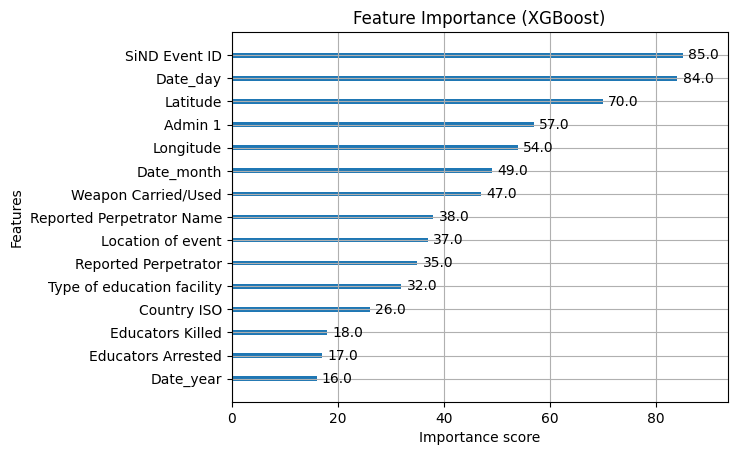

In [15]:
#feature importance plot
xgb.plot_importance(model, max_num_features=15, importance_type='weight')
plt.title("Feature Importance (XGBoost)")
plt.show()

In [16]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained model (not the notebook) with .joblib extension
from joblib import dump, load
model_path = os.path.join('models', 'training_model.joblib')

# Save the trained model instance, not the xgb module
with open(model_path, 'wb') as f:
    dump(model, f)  # Save the trained model instance
    print(f"Model saved successfully to {model_path}")

Model saved successfully to models\training_model.joblib
